## Time Series Forecasting on Motality Rate Dataset
- The data is fetched from the following API: https://api.covid19india.org/
- The data used is real-time and the code for extracting the csv file from covid-India api is present in task-1 folder 
- The steps performed in this file are:    
    1. Data Cleaning and Data pre-processing on the dataset
    2. Data Analysis through plotting of graphs
    3. Plotting the lag (day/month/year) and autocorrelation metrics 
    4. Performing KPSS test to check for the stationarity of dataset 
    5. Building auto-ARIMA model for prediction
    6. Building fbProphet model for prediction
    7. Results & Observations
    
    
- Notebook by Aditi Aggrawal 

### Data Cleaning & Data pre-processing

In [1]:
from fbprophet import Prophet

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

import pandas as pd

In [3]:
df = pd.read_csv('./Dataset/Mortality_Rate_delta.csv', parse_dates=['Date'], encoding='ISO-8859-1')
df.head()

State       Date  Confirmed  Recovered  Deceased  Tested
0    AN 2020-03-26        1.0        NaN       NaN     NaN
1    AN 2020-03-27        5.0        NaN       NaN     NaN
2    AN 2020-03-28        3.0        NaN       NaN     NaN
3    AN 2020-03-30        1.0        NaN       NaN     NaN
4    AN 2020-04-08        1.0        NaN       NaN     NaN

In [4]:
# df['Confirmed'] = df.groupby('State')['Confirmed'].diff().fillna(df['Confirmed'])
# df['Recovered'] = df.groupby('State')['Recovered'].diff().fillna(df['Recovered'])
# df['Deceased'] = df.groupby('State')['Deceased'].diff().fillna(df['Deceased'])
# df['Tested'] = df.groupby('State')['Tested'].diff().fillna(df['Tested'])
# df.head()

In [4]:
dict_states={'TT': 'Total', 'WB': 'West Bengal', 'DL': 'Delhi', 'KL': 'Kerala', 'PB': 'Punjab', 'AP':'Andhra Pradesh', 
             'TN': 'Tamil Nadu', 'KA': 'Karnataka', 'JK': 'Jammu and Kashmir', 'UP': 'Uttar Pradesh', 'MP': 'Madhya Pradesh', 
             'MH': 'Maharashtra', 'BR': 'Bihar', 'HR': 'Haryana', 'OR': 'Orissa', 'RJ': 'Rajasthan', 'GJ': 'Gujarat', 
             'HP': 'Himachal Pradesh', 'AS': 'Assam', 'TG': 'Telangana', 'JH': 'Jharkhand', 'ML': 'Meghalaya', 
             'UT': 'Uttarakhand', 'CH': 'Chandigarh', 'CT': 'Chhattisgarh', 'LA': 'Lakshadweep', 'TR': 'Tripura', 
             'PY': 'Pondicherry', 'GA': 'Goa', 'AR': 'Arunachal Pradesh', 'DN': 'Dadra and Nagar Haveli', 
             'NL': 'Nagaland', 'SK':'Sikkim', 'AN': 'Andaman and Nicobar Islands', 'MN': 'Manipur', 'MZ': 'Mizoram', 
             'LD': 'Lakshadweep'}
len(dict_states)

37

In [5]:
df['Year'] = df['Date'].dt.strftime('%Y')
df['Month'] = df['Date'].dt.strftime('%m')
df['Month']=pd.to_numeric(df['Month'])
df['Day'] = df['Date'].dt.strftime('%d')

df.head()

State       Date  Confirmed  Recovered  Deceased  Tested  Year  Month Day
0    AN 2020-03-26        1.0        NaN       NaN     NaN  2020      3  26
1    AN 2020-03-27        5.0        NaN       NaN     NaN  2020      3  27
2    AN 2020-03-28        3.0        NaN       NaN     NaN  2020      3  28
3    AN 2020-03-30        1.0        NaN       NaN     NaN  2020      3  30
4    AN 2020-04-08        1.0        NaN       NaN     NaN  2020      4  08

In [6]:
df.dropna(inplace=True)

In [7]:
df = df.replace({'State':dict_states})
df.Confirmed = df.Confirmed.astype(int)
df.Recovered = df.Recovered.astype(int)
df.Deceased = df.Deceased.astype(int)
df.Tested = df.Tested.astype(int)
df.head(10)

State       Date  Confirmed  Recovered  Deceased  \
91   Andaman and Nicobar Islands 2020-07-27         20         12         1   
93   Andaman and Nicobar Islands 2020-07-29         65          5         1   
95   Andaman and Nicobar Islands 2020-07-31         78         13         2   
96   Andaman and Nicobar Islands 2020-08-01         88         12         2   
97   Andaman and Nicobar Islands 2020-08-02         98         16         1   
98   Andaman and Nicobar Islands 2020-08-03         96         21         2   
99   Andaman and Nicobar Islands 2020-08-04         98         14         2   
100  Andaman and Nicobar Islands 2020-08-05         99         49         2   
101  Andaman and Nicobar Islands 2020-08-06         96         29         2   
102  Andaman and Nicobar Islands 2020-08-07         99         70         3   

     Tested  Year  Month Day  
91      499  2020      7  27  
93      292  2020      7  29  
95      423  2020      7  31  
96      270  2020      8  01  
97      272  2020      8  02  
98      454  2020      8  03  
99      458  2020      8  04  
100     334  2020      8  05  
101     690  2020      8  06  
102     399  2020      8  07

In [8]:
df_india = df.loc[df['State'] == 'Total']
df_india.head()

State       Date  Confirmed  Recovered  Deceased  Tested  Year  Month  \
15873  Total 2020-03-30        187         42        13   10754  2020      3   
15874  Total 2020-03-31        309         19         6    4346  2020      3   
15875  Total 2020-04-01        424          9        11    5163  2020      4   
15876  Total 2020-04-02        486         22        11    7900  2020      4   
15877  Total 2020-04-03        560         39        14   13394  2020      4   

      Day  
15873  30  
15874  31  
15875  01  
15876  02  
15877  03

### Data Analysis

In [9]:
df_india.describe()

Confirmed      Recovered     Deceased        Tested       Month
count     491.000000     491.000000   491.000000  4.910000e+02  491.000000
mean    64695.737271   62983.372709   867.063136  9.635736e+05    6.272912
std     86127.984696   84153.261505  1067.809397  6.572013e+05    3.067749
min       187.000000       9.000000     6.000000  4.346000e+03    1.000000
25%     15153.000000   14131.500000   187.500000  4.951925e+05    4.000000
50%     40314.000000   38545.000000   501.000000  9.314080e+05    6.000000
75%     68642.000000   68286.500000   980.000000  1.229246e+06    8.000000
max    414280.000000  422391.000000  6139.000000  3.740296e+06   12.000000

In [10]:
df_india_non_indexed=df_india.copy()

In [11]:
df_india = df_india.set_index('Date')
df_india.head()

State  Confirmed  Recovered  Deceased  Tested  Year  Month Day
Date                                                                      
2020-03-30  Total        187         42        13   10754  2020      3  30
2020-03-31  Total        309         19         6    4346  2020      3  31
2020-04-01  Total        424          9        11    5163  2020      4  01
2020-04-02  Total        486         22        11    7900  2020      4  02
2020-04-03  Total        560         39        14   13394  2020      4  03

In [12]:
confirmed_india = df_india['Confirmed']
recovered_india = df_india['Recovered']
deceased_india = df_india['Deceased']
tested_india = df_india['Tested']
confirmed_india.head()

Date
2020-03-30    187
2020-03-31    309
2020-04-01    424
2020-04-02    486
2020-04-03    560
Name: Confirmed, dtype: int32

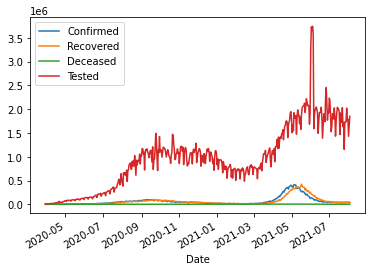

In [13]:
confirmed_india.plot()
recovered_india.plot()
deceased_india.plot()
tested_india.plot()
plt.legend()

In [14]:
import plotly.express as px
fig = px.line(df_india_non_indexed, x='Date', y='Confirmed', title='Confirmed with Slider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [15]:
fig = px.line(df_india_non_indexed, x='Date', y='Confirmed', title='Confirmed with Slider')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=4, label="4m", step="month", stepmode="backward"),
            dict(count=8, label="8m", step="month", stepmode="backward"),
            dict(count=12, label="12m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [16]:
df_india[['Month','Confirmed']].groupby('Month').describe()

Confirmed                                                            \
          count           mean            std      min       25%      50%   
Month                                                                       
1          31.0   15236.032258    2858.248584   9098.0  13152.50  15155.0   
2          28.0   12622.428571    2386.981364   8579.0  11444.25  12299.5   
3          33.0   33610.787879   19566.553607    187.0  18324.00  26513.0   
4          59.0  118109.694915  137989.447073    424.0   1046.00  81398.0   
5          62.0  147943.032258  156351.572017   2396.0   4669.50  67836.0   
6          60.0   43867.133333   37251.229747   7724.0  11880.25  28606.0   
7          62.0   37987.677419    8901.929525  19430.0  30818.50  39825.5   
8          34.0   61886.235294   10978.833981  30085.0  55494.25  63078.0   
9          30.0   87410.800000    7240.072677  69669.0  82989.25  87251.0   
10         31.0   60423.548387   12275.661570  36104.0  50277.00  60130.0   
11         30.0   42662.000000    5496.809689  28609.0  39615.25  44602.0   
12         31.0   26550.193548    6114.057847  16072.0  21943.00  26251.0   

                            
             75%       max  
Month                       
1       17462.00   20472.0  
2       13916.75   16930.0  
3       47239.00   72115.0  
4      225420.00  402014.0  
5      280424.50  414280.0  
6       62271.75  134044.0  
7       43419.25   57486.0  
8       68704.00   79461.0  
9       92873.25   97860.0  
10      71333.50   81785.0  
11      46002.25   50465.0  
12      30995.50   36711.0

In [17]:
df_india[['Month','Confirmed','Tested']].groupby('Month').agg({'Confirmed':['max'],'Tested':['min','max']})

Confirmed  Tested         
            max     min      max
Month                           
1         20472  504263   958125
2         16930  486122   831807
3         72115    4346  1181289
4        402014    5163  1945299
5        414280   60783  2217320
6        134044  108048  3740296
7         57486  180596  2230026
8         79461  381027  1847518
9         97860  709394  1492409
10        81785  859786  1469984
11        50465  805589  1283449
12        36711  715397  1171868

In [18]:
df_state = df[df.State != 'Total']

C:\Users\aditi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Confirmed cases')

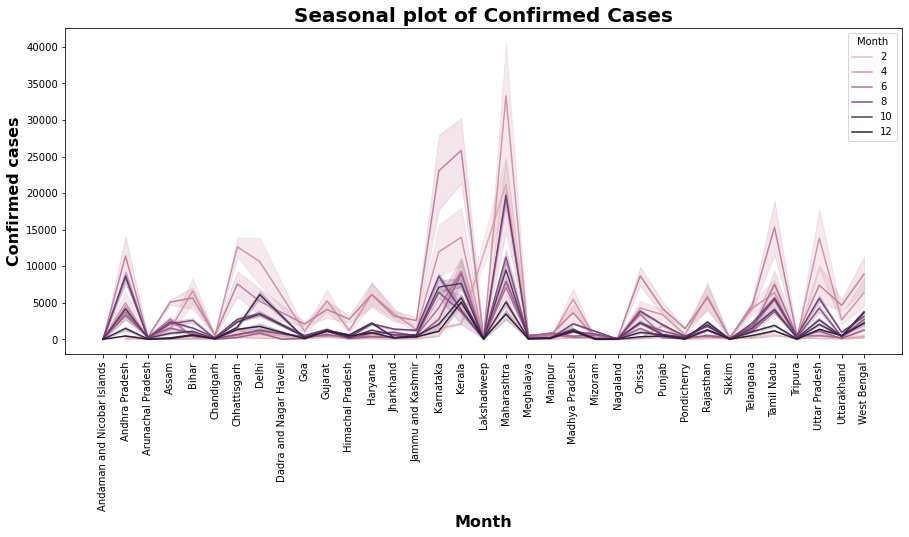

In [19]:
variable = 'Confirmed'
fig, ax = plt.subplots(figsize=(15, 6))


sns.lineplot(df_state['State'], df_state[variable], hue=df_state['Month'])
plt.xticks(rotation=90)
ax.set_title('Seasonal plot of Confirmed Cases', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Confirmed cases', fontsize = 16, fontdict=dict(weight='bold'))

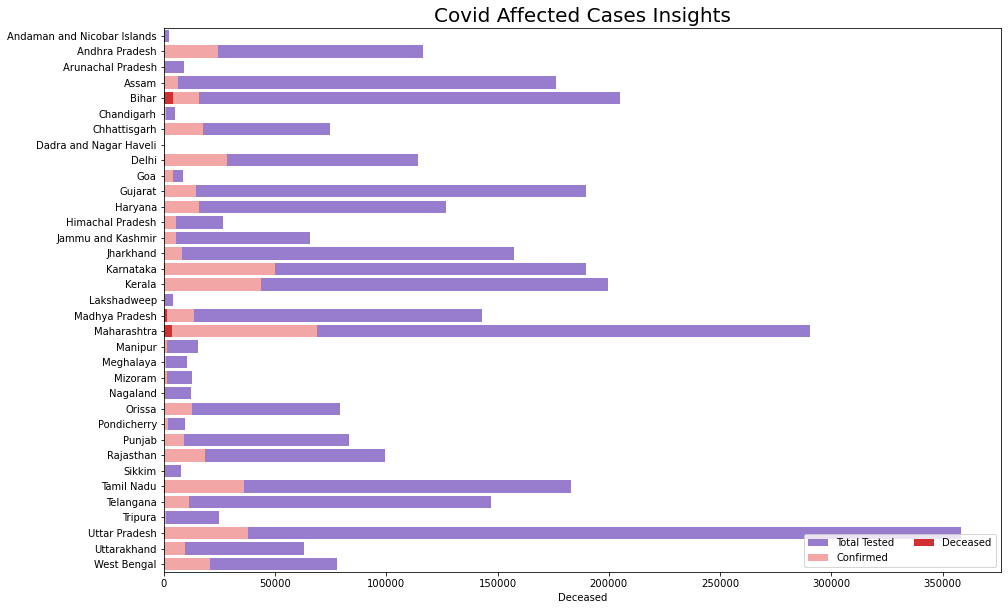

In [20]:
data_state = pd.pivot_table(df_state, values=['Tested','Confirmed','Recovered', 'Deceased'], index='State', aggfunc='max')
state_names = list(data_state.index)
data_state['State'] = state_names

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(x='Tested', y= state_names, data=data_state,label='Total Tested', color = '#9370db')
sns.barplot(x='Confirmed', y=state_names, data=data_state, label='Confirmed', color= '#ff9999')
#sns.barplot(x='Recovered', y=state_names, data=data_state, label='Recovered', color='#ff9999')
sns.barplot(x='Deceased', y=state_names, data=data_state, label='Deceased', color='#eb1515')
plt.title('Covid Affected Cases Insights',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

<AxesSubplot:xlabel='State'>

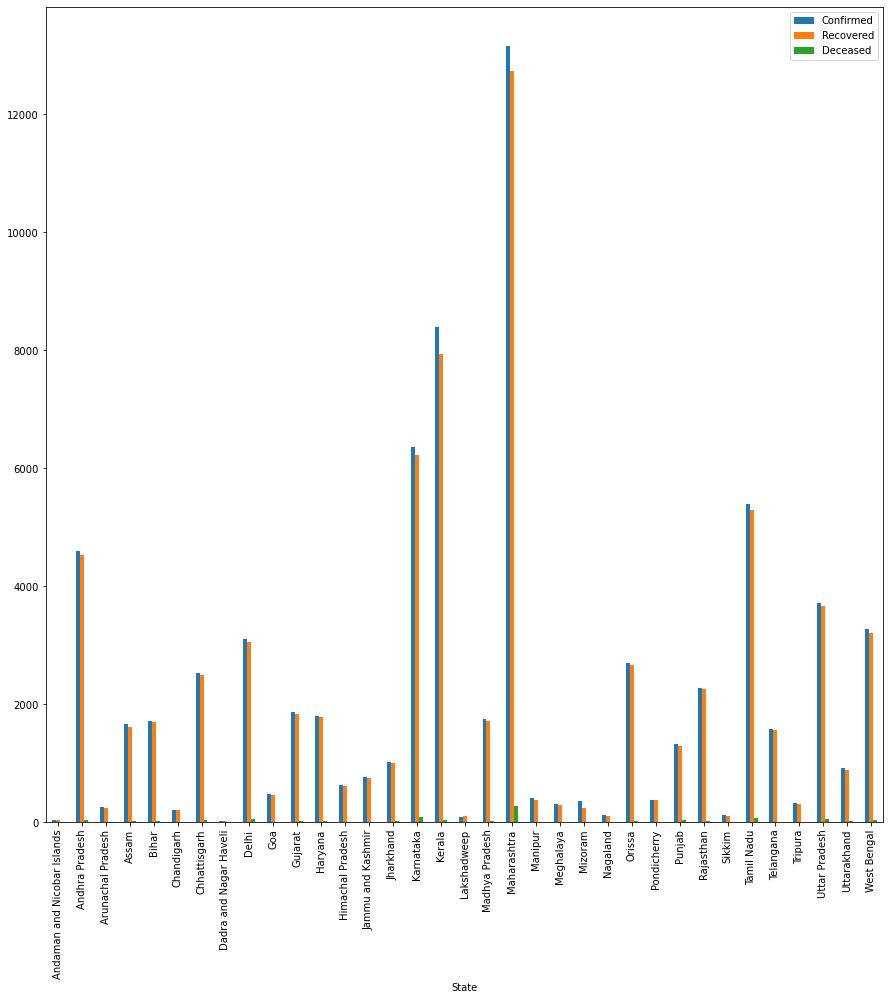

In [98]:
data_state_mean = pd.pivot_table(df_state, values=['Tested','Confirmed','Recovered', 'Deceased'], index='State', aggfunc='mean')
data_state_mean.plot(y=["Confirmed", "Recovered", "Deceased"], use_index=True, kind="bar", figsize=(15,15))
# df_india_non_indexed.head()
# data_state_mean.head()

In [21]:
df_confirmed = df.drop(labels=['Recovered', 'Deceased', 'Tested'], axis=1)
df_recovered = df.drop(labels=['Confirmed', 'Deceased', 'Tested'], axis=1)
df_deceased = df.drop(labels=['Recovered', 'Confirmed', 'Tested'], axis=1)

df_confirmed.head()

State       Date  Confirmed  Year  Month Day
91  Andaman and Nicobar Islands 2020-07-27         20  2020      7  27
93  Andaman and Nicobar Islands 2020-07-29         65  2020      7  29
95  Andaman and Nicobar Islands 2020-07-31         78  2020      7  31
96  Andaman and Nicobar Islands 2020-08-01         88  2020      8  01
97  Andaman and Nicobar Islands 2020-08-02         98  2020      8  02

### Studying auto correlation between metrics

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

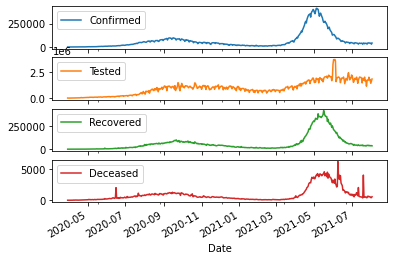

In [22]:
data_india_CTRD=df_india[['Confirmed','Tested', 'Recovered', 'Deceased']]
data_india_CTRD.plot(subplots=True)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

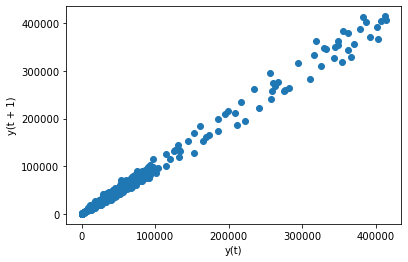

In [23]:
pd.plotting.lag_plot(df_india['Confirmed'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

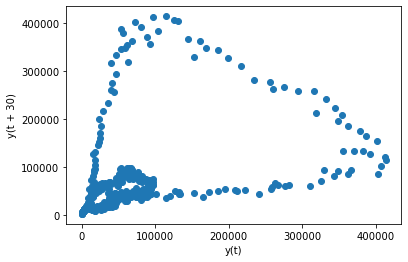

In [24]:
pd.plotting.lag_plot(df_india['Confirmed'],lag=30)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

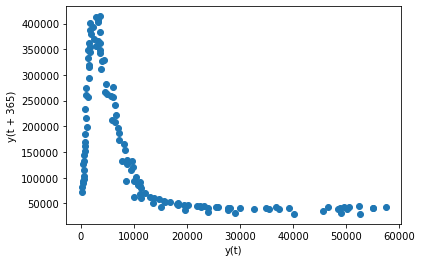

In [25]:
pd.plotting.lag_plot(df_india['Confirmed'],lag=365)

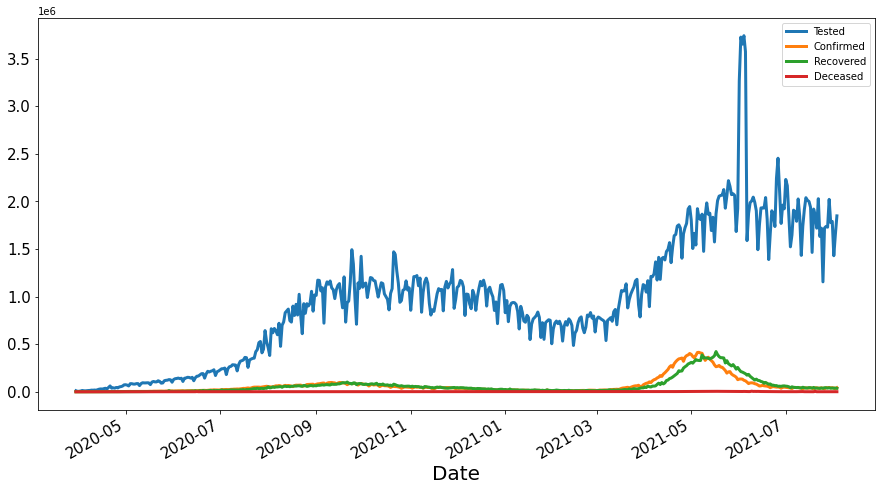

In [26]:
df_india[['Tested', 'Confirmed', 'Recovered', 'Deceased']].plot(figsize=(15,8), linewidth=3, fontsize=15)
plt.xlabel('Date', fontsize=20);


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

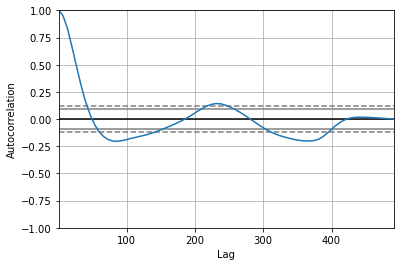

In [27]:
pd.plotting.autocorrelation_plot(df_india['Confirmed'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

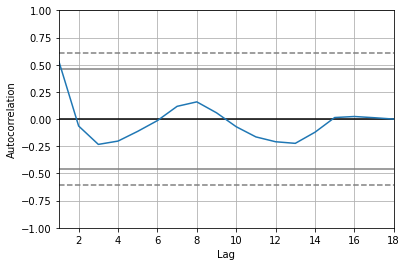

In [28]:
pd.plotting.autocorrelation_plot(df_india['Confirmed'].resample('1m').mean())

### Performing KPSS test for stationarity

In [30]:
from statsmodels.tsa.stattools import kpss


In [29]:
df_india_2021 = df_india[(df_india.index.get_level_values(0)) >= '2021-01-01']
df_india_2021

State  Confirmed  Recovered  Deceased   Tested  Year  Month Day
Date                                                                       
2021-01-01  Total      20159      23838       237   829964  2021      1  01
2021-01-02  Total      18144      20903       216   958125  2021      1  02
2021-01-03  Total      16678      19658       215   735978  2021      1  03
2021-01-04  Total      16278      29209       200   896236  2021      1  04
2021-01-05  Total      17909      21161       265   931408  2021      1  05
...           ...        ...        ...       ...      ...   ...    ...  ..
2021-07-30  Total      41499      37320       598  1776315  2021      7  30
2021-07-31  Total      41943      39485       542  1789472  2021      7  31
2021-08-01  Total      40629      36628       424  1428984  2021      8  01
2021-08-02  Total      30085      39120       420  1649295  2021      8  02
2021-08-03  Total      42530      36552       561  1847518  2021      8  03

[215 rows x 8 columns]

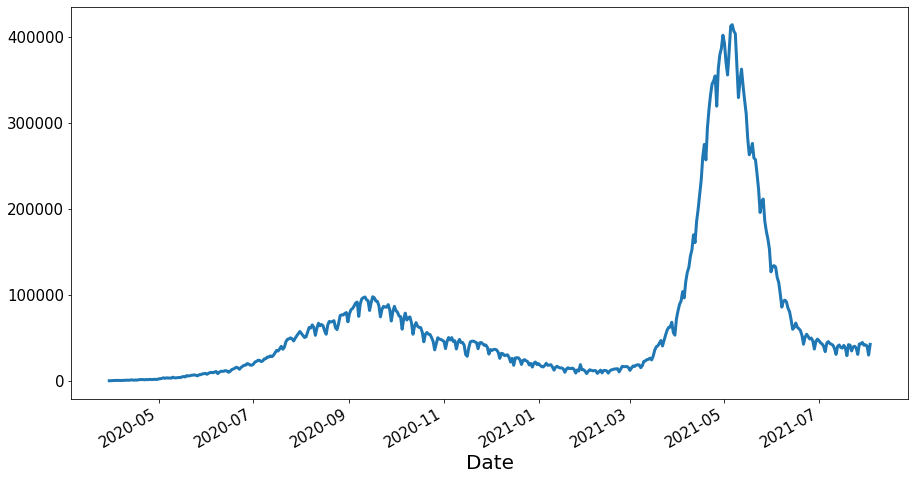

In [32]:
df_india['Confirmed'].plot(figsize=(15,8), linewidth=3, fontsize=15)
plt.xlabel('Date', fontsize=20);

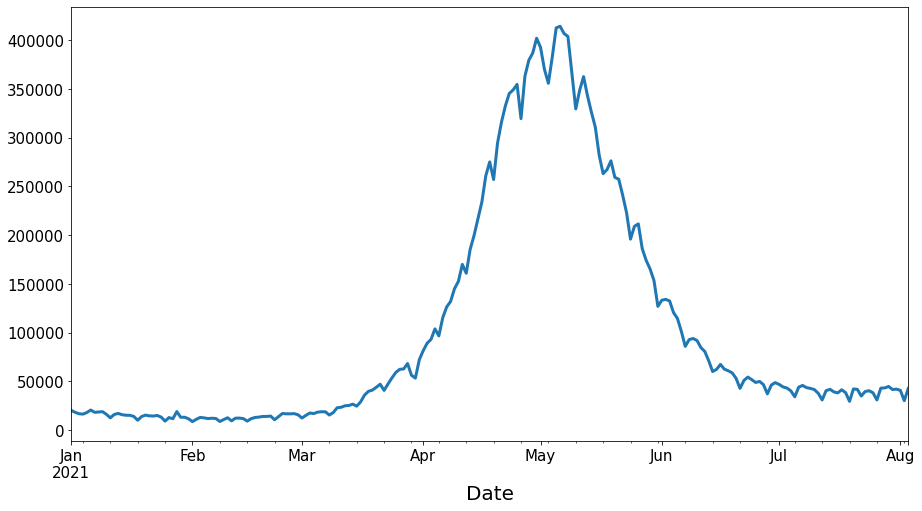

In [33]:
df_india_2021['Confirmed'].plot(figsize=(15,8), linewidth=3, fontsize=15)
plt.xlabel('Date', fontsize=20);

In [34]:
def isStationaryKPSS(stats, p, critical_values):
    print(f'Test Statistics: {stats}')
    print(f'p-value: {p}')
    print(f'Critial Values: {critical_values}')

    if p < 0.05 :
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [35]:
stats, p, lags, critical_values = kpss(df_india_2021['Confirmed'])
isStationaryKPSS(stats, p, critical_values)

C:\Users\aditi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



Test Statistics: 0.3369171436076695
p-value: 0.1
Critial Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is Stationary


C:\Users\aditi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [36]:
stats, p, lags, critical_values = kpss(df_india['Confirmed'])
isStationaryKPSS(stats, p, critical_values)

Test Statistics: 0.6269163962171281
p-value: 0.02018941852571562
Critial Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is not Stationary


In [37]:
from statsmodels.tsa.stattools import adfuller

In [38]:
def isStationaryADF(df, col):
    result = adfuller(df[col])
    
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critial Values: {result[4]}')

    if result[1] > 0.05 :
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [39]:
isStationaryADF(df_india, 'Confirmed')

Test Statistics: -3.301749470755197
p-value: 0.014800453984489117
Critial Values: {'1%': -3.444250937448703, '5%': -2.867669873870454, '10%': -2.5700349866579657}
Series is Stationary


In [40]:
isStationaryADF(df_india_2021, 'Confirmed')

Test Statistics: -2.540359566957262
p-value: 0.10596060337377139
Critial Values: {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}
Series is not Stationary


### Auto-ARIMA model

In [100]:
import pmdarima as pm


In [101]:
def auto_arima(df, split_date, cur_m, isSeasonal, cur_max_order):
    model = pm.auto_arima(df['Confirmed'], 
                            m=cur_m, seasonal=isSeasonal,
                          start_p=0, start_q=0, max_order=cur_max_order, test='adf',error_action='ignore',  
                          stepwise=True, trace=True)
    #model.summary()
    
    train=df[(df.index.get_level_values(0) <= split_date)]
    test=df[(df.index.get_level_values(0) > split_date)]
    
    
    cur_periods = test.shape[0]
    model.fit(train['Confirmed'])
    
    forecast=model.predict(n_periods=cur_periods, return_conf_int=True)
    forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])
    
    return forecast_df
    

### 1. for df_india

In [102]:
forecast_df1 = auto_arima(df_india, '2021-01-01', 12, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=12195.670, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12555.442, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12773.476, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=12337.230, Time=0.26 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=12192.120, Time=0.48 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=12253.117, Time=1.82 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=12167.568, Time=0.91 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=12165.749, Time=0.63 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=12175.016, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=10215.467, Time=1.14 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=10218.248, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[12

In [ ]:
forecast_df2 = auto_arima(df_india, '2021-05-01', 12, True, 4)

In [82]:
forecast_df3 = auto_arima(df_india, '2021-05-01', 6, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=12150.725, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=12555.442, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=12773.476, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=12277.403, Time=0.18 sec
 ARIMA(0,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,0)(1,0,2)[6] intercept   : AIC=12127.236, Time=0.99 sec
 ARIMA(0,0,0)(0,0,2)[6] intercept   : AIC=12145.173, Time=0.33 sec
 ARIMA(0,0,0)(2,0,2)[6] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(1,0,0)(1,0,2)[6] intercept   : AIC=10186.190, Time=2.19 sec
 ARIMA(1,0,0)(0,0,2)[6] intercept   : AIC=10187.905, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=10186.278, Time=0.87 sec
 ARIMA(1,0,0)(2,0,2)[6] intercept   : AIC=10188.0

In [86]:
forecast_df4 = auto_arima(df_india, '2021-07-01', 6, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=12150.725, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=12555.442, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=12773.476, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=12277.403, Time=0.17 sec
 ARIMA(0,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,0,0)(1,0,2)[6] intercept   : AIC=12127.236, Time=0.93 sec
 ARIMA(0,0,0)(0,0,2)[6] intercept   : AIC=12145.173, Time=0.31 sec
 ARIMA(0,0,0)(2,0,2)[6] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(1,0,0)(1,0,2)[6] intercept   : AIC=10186.190, Time=2.16 sec
 ARIMA(1,0,0)(0,0,2)[6] intercept   : AIC=10187.905, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=10186.278, Time=0.82 sec
 ARIMA(1,0,0)(2,0,2)[6] intercept   : AIC=10188.0

In [87]:
forecast_df5 = auto_arima(df_india, '2021-06-01', 6, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=12150.725, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=12555.442, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=12773.476, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=12277.403, Time=0.24 sec
 ARIMA(0,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(1,0,2)[6] intercept   : AIC=12127.236, Time=0.82 sec
 ARIMA(0,0,0)(0,0,2)[6] intercept   : AIC=12145.173, Time=0.34 sec
 ARIMA(0,0,0)(2,0,2)[6] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(1,0,0)(1,0,2)[6] intercept   : AIC=10186.190, Time=2.20 sec
 ARIMA(1,0,0)(0,0,2)[6] intercept   : AIC=10187.905, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=10186.278, Time=0.84 sec
 ARIMA(1,0,0)(2,0,2)[6] intercept   : AIC=10188.0

In [90]:
forecast_df6 = auto_arima(df_india, '2021-06-15', 6, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=12150.725, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=12555.442, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=12773.476, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=12277.403, Time=0.23 sec
 ARIMA(0,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,0,0)(1,0,2)[6] intercept   : AIC=12127.236, Time=0.82 sec
 ARIMA(0,0,0)(0,0,2)[6] intercept   : AIC=12145.173, Time=0.21 sec
 ARIMA(0,0,0)(2,0,2)[6] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(1,0,0)(1,0,2)[6] intercept   : AIC=10186.190, Time=2.20 sec
 ARIMA(1,0,0)(0,0,2)[6] intercept   : AIC=10187.905, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=10186.278, Time=0.83 sec
 ARIMA(1,0,0)(2,0,2)[6] intercept   : AIC=10188.0

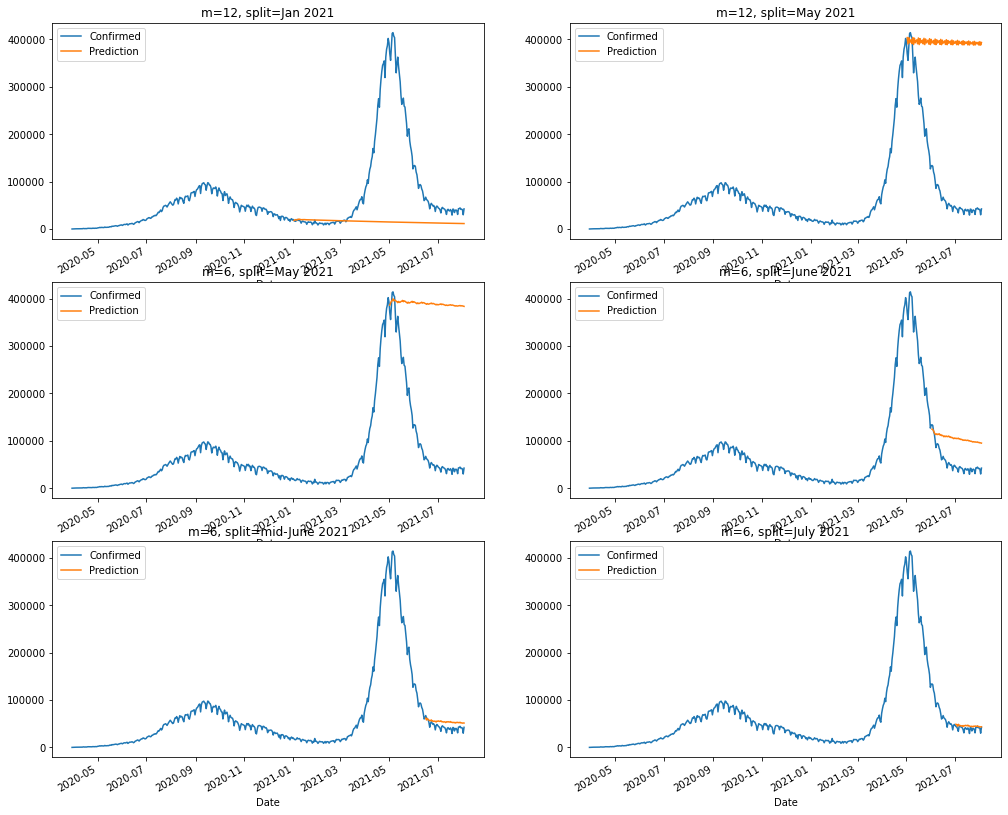

In [114]:
nrow=3
ncol=2

df1 = pd.concat([df_india['Confirmed'],forecast_df1],axis=1)
df2 = pd.concat([df_india['Confirmed'],forecast_df2],axis=1)
df3 = pd.concat([df_india['Confirmed'],forecast_df3],axis=1)
df4 = pd.concat([df_india['Confirmed'],forecast_df4],axis=1)
df5 = pd.concat([df_india['Confirmed'],forecast_df5],axis=1)
df6 = pd.concat([df_india['Confirmed'],forecast_df6],axis=1)

titles = [['m=12, split=Jan 2021', 'm=12, split=May 2021'], ['m=6, split=May 2021', 'm=6, split=June 2021'], 
          ['m=6, split=mid-June 2021', 'm=6, split=July 2021']]
df_list = [df1, df2, df3, df5, df6, df4]
fig, axes = plt.subplots(nrow, ncol)

count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], figsize=(17,15), title=titles[r][c])

        count+=1

### 2. for df_india_2021

In [44]:
forecast_df7 = auto_arima(df_india_2021, '2021-05-01', 12, True, None)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.40 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.91 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.34 sec
 ARIMA(1,1,1)(2,0,0)[12]

In [45]:
forecast_df8 = auto_arima(df_india_2021, '2021-05-01', 6, True, None)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=4575.770, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=4578.513, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=4576.020, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=4588.268, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=4574.557, Time=0.08 sec
 ARIMA(0,1,0)(0,0,2)[6] intercept   : AIC=4575.970, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=4577.390, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[6] intercept   : AIC=4576.859, Time=0.53 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=4575.884, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=4578.009, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[6]             : AIC=4574.710, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,1)[6] intercept
Total fit time: 1.702 seconds


In [46]:
forecast_df9 = auto_arima(df_india_2021, '2021-05-01', 1, False, None)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4580.696, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4580.310, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4582.263, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4582.468, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4570.932, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4561.687, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4576.058, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4562.520, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4572.186, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4606.054, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4563.528, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4520.991, Time=1.14 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

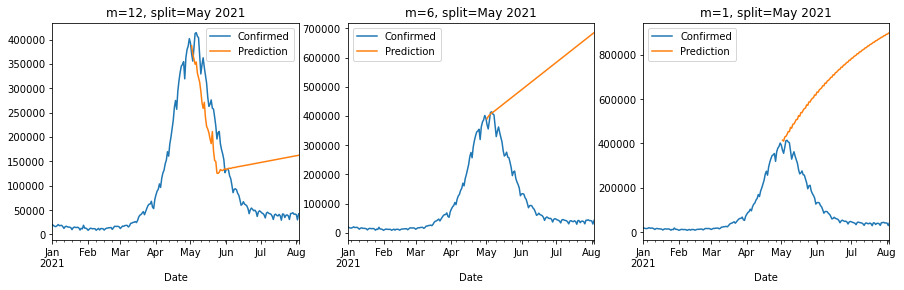

In [64]:
nrow=1
ncol=3

df7 = pd.concat([df_india_2021['Confirmed'],forecast_df7],axis=1)
df8 = pd.concat([df_india_2021['Confirmed'],forecast_df8],axis=1)
df9 = pd.concat([df_india_2021['Confirmed'],forecast_df9],axis=1)

titles = [['m=12, split=May 2021', 'm=6, split=May 2021', 'm=1, split=May 2021']]

df_list = [df7, df8, df9]
fig, axes = plt.subplots(nrow, ncol)

count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[c], figsize=(15,4), title=titles[r][c])

        count+=1


In [65]:
forecast_df10 = auto_arima(df_india_2021, '2021-05-01', 12, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.37 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.40 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.91 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.12 sec
 ARIMA(1,1,1)(2,0,0)[12]

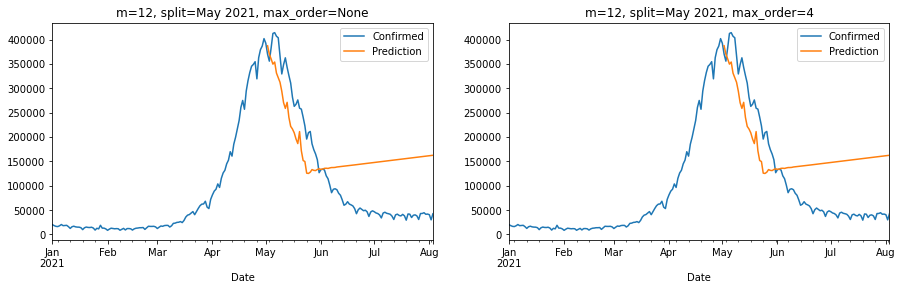

In [66]:
nrow=1
ncol=2

df7 = pd.concat([df_india_2021['Confirmed'],forecast_df7],axis=1)
df10 = pd.concat([df_india_2021['Confirmed'],forecast_df10],axis=1)

titles = [['m=12, split=May 2021, max_order=None', 'm=12, split=May 2021, max_order=4']]

df_list = [df7, df10]
fig, axes = plt.subplots(nrow, ncol)

count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[c], figsize=(15,4), title=titles[r][c])

        count+=1


In [67]:
forecast_df11 = auto_arima(df_india_2021, '2021-06-01', 12, True, None)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.90 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.13 sec
 ARIMA(1,1,1)(2,0,0)[12]

In [87]:
forecast_df12 = auto_arima(df_india_2021, '2021-07-01', 12, True, None)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.33 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.40 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.92 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.13 sec
 ARIMA(1,1,1)(2,0,0)[12]

In [92]:
forecast_df13 = auto_arima(df_india_2021, '2021-07-15', 12, True, 4)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.37 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.19 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.12 sec
 ARIMA(1,1,1)(2,0,0)[12]

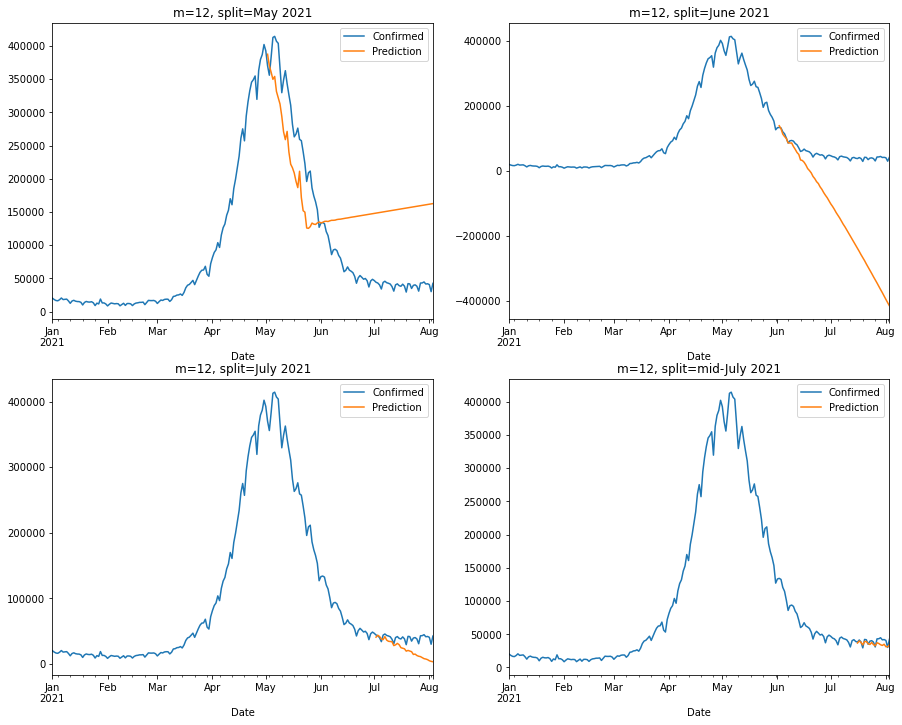

In [95]:
nrow=2
ncol=2

df7 = pd.concat([df_india_2021['Confirmed'],forecast_df7],axis=1)
df11 = pd.concat([df_india_2021['Confirmed'],forecast_df11],axis=1)
df12 = pd.concat([df_india_2021['Confirmed'],forecast_df12],axis=1)
df13 = pd.concat([df_india_2021['Confirmed'],forecast_df13[1]],axis=1)

titles = [['m=12, split=May 2021', 'm=12, split=June 2021'], ['m=12, split=July 2021', 'm=12, split=mid-July 2021']]
df_list = [df7, df11, df12, df13]
fig, axes = plt.subplots(nrow, ncol)

count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], figsize=(15,12), title=titles[r][c])

        count+=1

## for the final model

In [99]:
model = pm.auto_arima(df_india_2021['Confirmed'], 
                            m=12, seasonal=True,
                          start_p=0, start_q=0, max_order=None, test='adf',error_action='ignore',  
                          stepwise=True, trace=True)
    


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4590.246, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4579.809, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4581.159, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4580.696, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4581.734, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4581.063, Time=0.42 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4579.843, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4583.063, Time=0.90 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4592.162, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4580.967, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4563.726, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4582.263, Time=0.12 sec
 ARIMA(1,1,1)(2,0,0)[12]

NameError: name 'df_india_2021_india_2021' is not defined

In [100]:
train=df_india_2021[(df_india_2021.index.get_level_values(0) <= '2021-07-15')]
test=df_india_2021[(df_india_2021.index.get_level_values(0) > '2021-07-15')]
    
cur_periods = test.shape[0]
model.fit(train['Confirmed'])
    
forecast=model.predict(n_periods=cur_periods, return_conf_int=True)
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])

In [105]:
forecast_range=pd.date_range(start='2021-07-15', periods=cur_periods, freq='D')

lower=pd.Series(forecast[1][:, 0], index =forecast_range)
upper=pd.Series(forecast[1][:, 1], index =forecast_range)

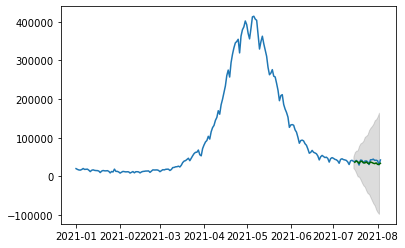

In [106]:
plt.plot(df_india_2021['Confirmed'])
plt.plot(forecast_df, color='darkgreen')
plt.fill_between(forecast_range, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

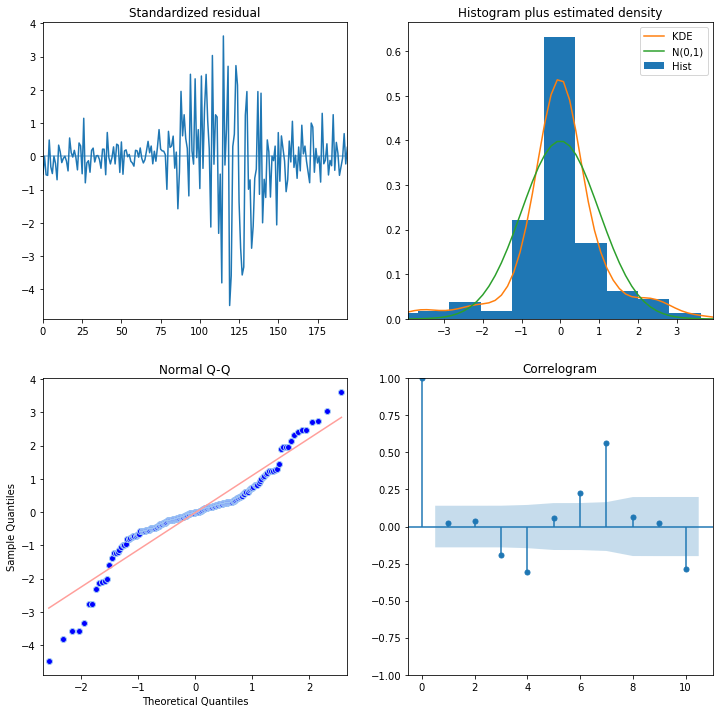

In [109]:
out=model.plot_diagnostics(figsize=(12,12))


## fbProphet model 

In [30]:
def apply_prophet(df, split_date, isSeasonality):
    
    train=df[(df['ds'] <= split_date)]
    test=df[(df['ds'] > split_date)]

    cur_periods = test.shape[0]
    print(cur_periods)
    
    model = Prophet(interval_width=0.95, yearly_seasonality = isSeasonality)
    model.fit(train)
    model.params
    
    future = model.make_future_dataframe(periods=cur_periods)
    future.tail()
    
    forecast = model.predict(future)
    
    return model, forecast

## 1. for df_india

In [31]:
df_india_prophet = df_india.reset_index()[['Date','Confirmed']].rename({'Date':'ds','Confirmed':'y'}, axis='columns')
df_india_prophet

ds      y
0   2020-03-30    187
1   2020-03-31    309
2   2020-04-01    424
3   2020-04-02    486
4   2020-04-03    560
..         ...    ...
486 2021-07-30  41499
487 2021-07-31  41943
488 2021-08-01  40629
489 2021-08-02  30085
490 2021-08-03  42530

[491 rows x 2 columns]

In [32]:
model1, forecast1 = apply_prophet(df_india_prophet, '2021-01-01', False)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

214


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds          yhat     yhat_lower     yhat_upper
486 2021-07-30 -84858.391792 -264142.288936   97484.585099
487 2021-07-31 -85518.569590 -258972.977756   99743.953135
488 2021-08-01 -87750.411880 -263575.791575  101058.490105
489 2021-08-02 -93526.129689 -273899.938956   97244.459052
490 2021-08-03 -89232.710861 -269802.124200  104138.627958

In [33]:
model2, forecast2 = apply_prophet(df_india_prophet, '2021-03-01', False)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


155


ds          yhat     yhat_lower    yhat_upper
486 2021-07-30 -19455.487797 -141446.282808  91194.928360
487 2021-07-31 -19743.663983 -138455.915322  93965.354117
488 2021-08-01 -21521.825349 -146192.325898  92184.723053
489 2021-08-02 -26554.401344 -150201.593223  90646.222056
490 2021-08-03 -22446.333458 -146645.100110  91491.435917

In [34]:
model3, forecast3 = apply_prophet(df_india_prophet, '2021-06-01', False)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63


ds           yhat     yhat_lower     yhat_upper
486 2021-07-30  504510.008385  411875.785839  608140.671529
487 2021-07-31  506595.900246  420644.281945  595063.130681
488 2021-08-01  506640.402197  421330.842297  599018.509586
489 2021-08-02  501640.228103  413547.769115  594323.876214
490 2021-08-03  510740.036608  421014.792065  609355.833917

In [35]:
model4, forecast4 = apply_prophet(df_india_prophet, '2021-07-01', False)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33


ds           yhat    yhat_lower     yhat_upper
486 2021-07-30  214056.367923  75140.717348  353543.076107
487 2021-07-31  214130.310324  87423.079214  358207.040735
488 2021-08-01  211962.916786  65003.081196  352411.227677
489 2021-08-02  204770.358987  69375.523102  348100.332187
490 2021-08-03  211852.945698  76053.333889  351952.609564

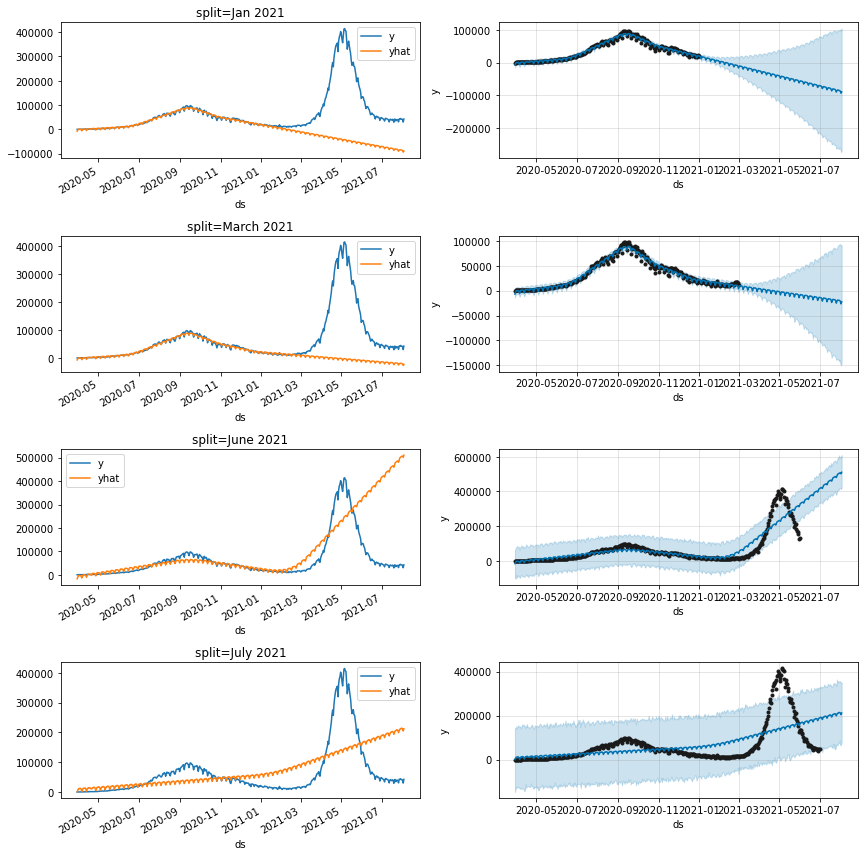

In [64]:
nrow=4
ncol=2

df1 = pd.concat([df_india_prophet.set_index('ds')['y'],forecast1.set_index('ds')['yhat']],axis=1)
df2 = pd.concat([df_india_prophet.set_index('ds')['y'],forecast2.set_index('ds')['yhat']],axis=1)
df3 = pd.concat([df_india_prophet.set_index('ds')['y'],forecast3.set_index('ds')['yhat']],axis=1)
df4 = pd.concat([df_india_prophet.set_index('ds')['y'],forecast4.set_index('ds')['yhat']],axis=1)

titles = ['split=Jan 2021', 'split=March 2021', 'split=June 2021', 'split=July 2021']

df_list = [df1, df2, df3, df4]
model_list = [model1, model2, model3, model4]
forecast_list = [forecast1, forecast2, forecast3, forecast4]

fig, axes = plt.subplots(nrow, ncol)

for r in range(nrow):
    df_list[r].plot(ax=axes[r, 0], title=titles[r], figsize=(12,12))
    model_list[r].plot(forecast_list[r], ax=axes[r, 1], figsize=(12,12))
    

### 2. for df_india_2021

In [73]:
df_india_2021_prophet = df_india_2021.reset_index()[['Date','Confirmed']].rename({'Date':'ds','Confirmed':'y'}, axis='columns')
df_india_2021_prophet

ds      y
0   2021-01-01  20159
1   2021-01-02  18144
2   2021-01-03  16678
3   2021-01-04  16278
4   2021-01-05  17909
..         ...    ...
210 2021-07-30  41499
211 2021-07-31  41943
212 2021-08-01  40629
213 2021-08-02  30085
214 2021-08-03  42530

[215 rows x 2 columns]

In [82]:
model5, forecast5 = apply_prophet(df_india_2021_prophet, '2021-07-15', True)
forecast5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19


ds           yhat    yhat_lower     yhat_upper
210 2021-07-30   82233.077939  69558.500762   95994.873033
211 2021-07-31   87421.567867  75064.573617  100072.933701
212 2021-08-01   89622.023700  76502.696137  103108.991218
213 2021-08-02   84940.810329  72104.928113   98237.951269
214 2021-08-03  100932.269383  87736.973507  113754.728561

In [75]:
model6, forecast6 = apply_prophet(df_india_2021_prophet, '2021-03-01', True)
forecast6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


155


ds          yhat    yhat_lower    yhat_upper
210 2021-07-30  -2653.310177  -4429.185514   -766.839211
211 2021-07-31 -10416.884183 -12432.869635  -8510.018029
212 2021-08-01 -19358.945516 -21227.357115 -17454.690778
213 2021-08-02 -30178.603789 -31986.416196 -28204.487478
214 2021-08-03 -34758.131567 -36731.303936 -32824.857687

In [77]:
model7, forecast7 = apply_prophet(df_india_2021_prophet, '2021-06-01', True)
forecast7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63


ds           yhat     yhat_lower     yhat_upper
210 2021-07-30  170751.442441  156182.891507  185059.682180
211 2021-07-31  166795.436123  152421.839684  181885.180749
212 2021-08-01  161166.275105  147207.086521  176610.408844
213 2021-08-02  148868.161043  135041.394076  163083.241203
214 2021-08-03  159400.723413  145479.987338  172774.717859

In [78]:
model8, forecast8 = apply_prophet(df_india_2021_prophet, '2021-07-01', True)
forecast6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33


ds          yhat    yhat_lower    yhat_upper
210 2021-07-30  -2653.310177  -4429.185514   -766.839211
211 2021-07-31 -10416.884183 -12432.869635  -8510.018029
212 2021-08-01 -19358.945516 -21227.357115 -17454.690778
213 2021-08-02 -30178.603789 -31986.416196 -28204.487478
214 2021-08-03 -34758.131567 -36731.303936 -32824.857687

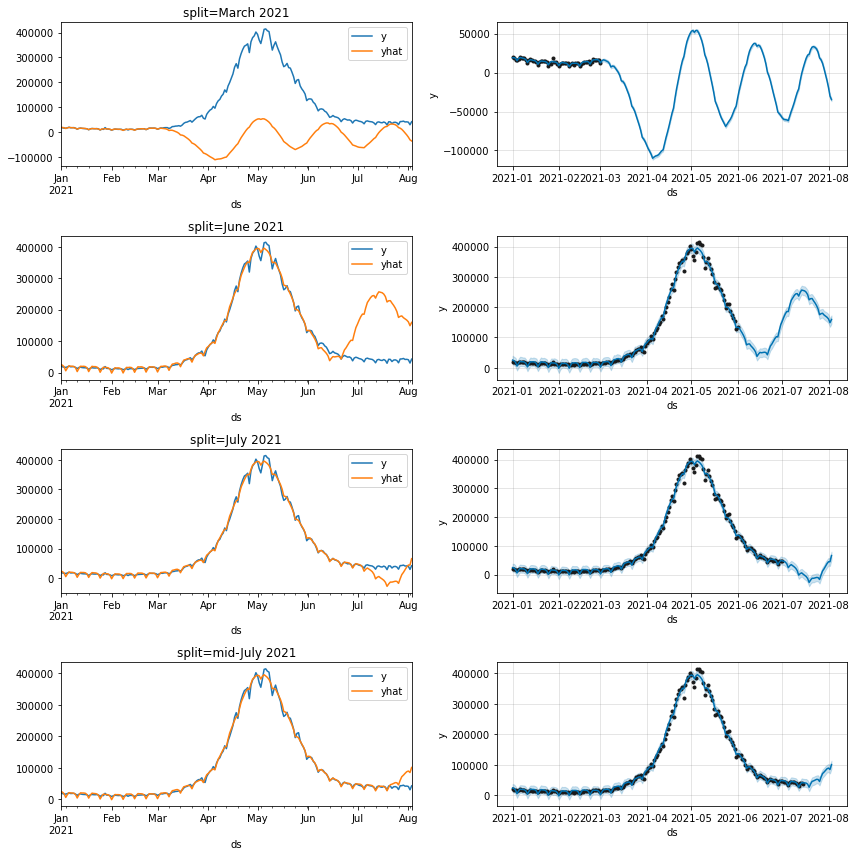

In [83]:
nrow=4
ncol=2

df5 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast5.set_index('ds')['yhat']],axis=1)
df6 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast6.set_index('ds')['yhat']],axis=1)
df7 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast7.set_index('ds')['yhat']],axis=1)
df8 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast8.set_index('ds')['yhat']],axis=1)

titles = ['split=March 2021', 'split=June 2021', 'split=July 2021', 'split=mid-July 2021']

df_list = [df6, df7, df8, df5]
model_list = [model6, model7, model8, model5]
forecast_list = [forecast6, forecast7, forecast8, forecast5]

fig, axes = plt.subplots(nrow, ncol)

for r in range(nrow):
    df_list[r].plot(ax=axes[r, 0], title=titles[r], figsize=(12,12))
    model_list[r].plot(forecast_list[r], ax=axes[r, 1], figsize=(12,12))
    

In [80]:
model9, forecast9 = apply_prophet(df_india_2021_prophet, '2021-07-01', False)
forecast9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33


ds          yhat     yhat_lower     yhat_upper
210 2021-07-30  14119.739733 -134353.834606  161645.192914
211 2021-07-31   9754.358387 -138216.015316  152138.000359
212 2021-08-01   2213.077494 -140929.603323  140709.857062
213 2021-08-02 -12533.295598 -166021.063121  134620.146069
214 2021-08-03  -6161.053978 -142110.996868  144237.135692

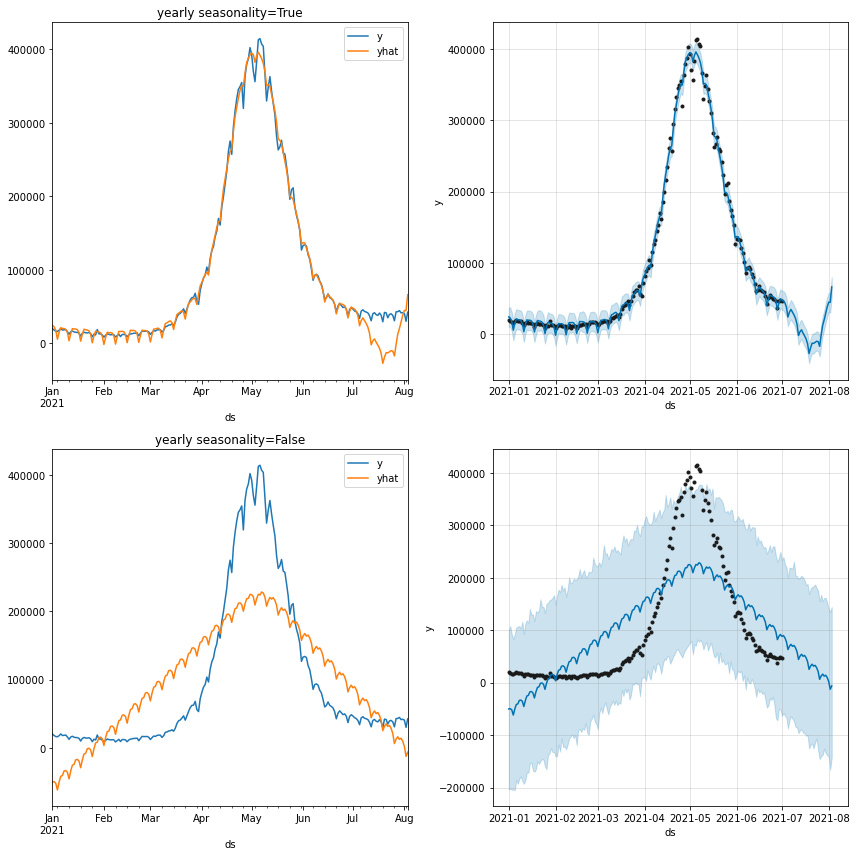

In [81]:
nrow=2
ncol=2

df8 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast8.set_index('ds')['yhat']],axis=1)
df9 = pd.concat([df_india_2021_prophet.set_index('ds')['y'],forecast9.set_index('ds')['yhat']],axis=1)

titles = ['yearly seasonality=True', 'yearly seasonality=False']

df_list = [df8, df9]
model_list = [model8, model9]
forecast_list = [forecast8, forecast9]

fig, axes = plt.subplots(nrow, ncol)

for r in range(nrow):
    df_list[r].plot(ax=axes[r, 0], title=titles[r], figsize=(12,12))
    model_list[r].plot(forecast_list[r], ax=axes[r, 1], figsize=(12,12))

## for the best model

<AxesSubplot:xlabel='ds'>

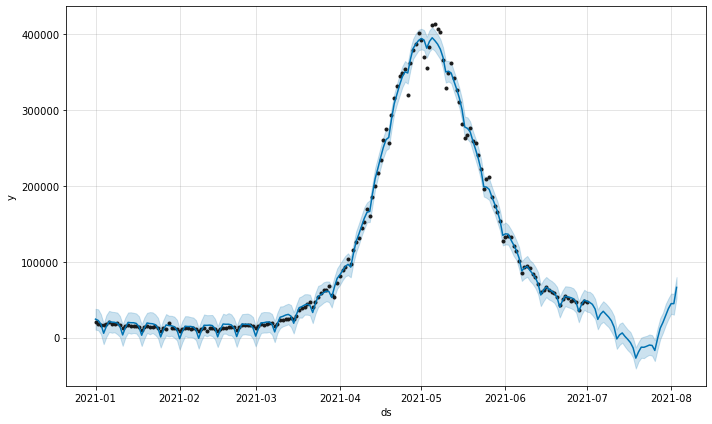

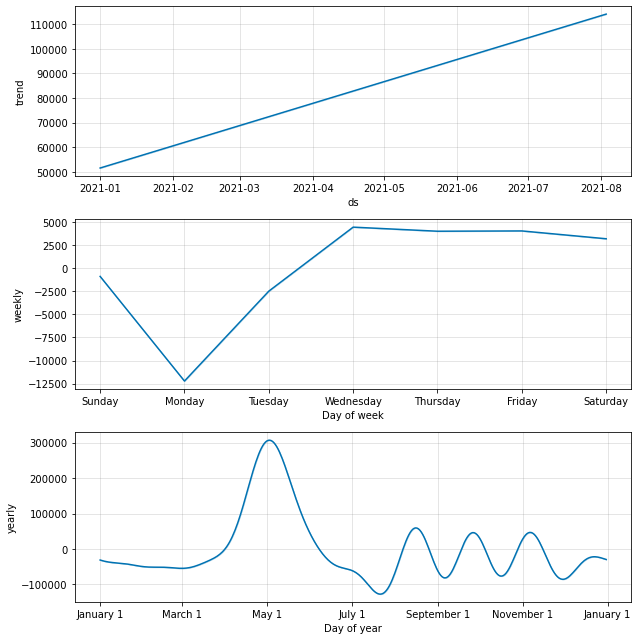

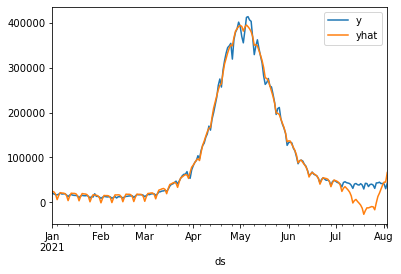

In [85]:
model8.plot(forecast8)
model8.plot_components(forecast8)
df8.plot()

## Observations
- Our data over 2020 & 2021 is non-stationary while for 2021 it is stationary
- in either of the models, as we provide more training set, the accuracy of prediction increases
- Since there is no fixed trend that has been observed over 2020 & 2021 as a whole, each of the models perform better when trained on only 2021 dataset 
- performance of fbProphet model is much better than that of ARIMA model